In [1]:
# Parsing each log line accroding to the pattern set.


import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

In [2]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

In [3]:
#Creating RDD
import sys
import os
from test_helper import Test

baseDir = os.path.join('data')
inputPath = os.path.join('Nirbhay', '272', 'apache.access.log.PROJECT')
logFile = os.path.join(baseDir, inputPath)

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Number of invalid logline: 108
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:39 -0400] "GET / HTTP/1.0 " 200 7131
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:43:57 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0 " 200 5866
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:07 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0 " 200 786
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:11 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0 " 200 363
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:13 -0400] "GET /images/USA-logosmall.gif HTTP/1.0 " 200 234
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:15 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0 " 200 669
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:31 -0400] "GET /shuttle/countdown/ HTTP/1.0 " 200 4673
Invalid logline: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:41 -0400] "GET /shuttle/missions/sts-69/count69.g

In [4]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 17531, Min: 0, Max: 3421948


In [6]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())


In [7]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 404, 500, 501, 302, 403]
[0.9018981486363797, 0.07652801492518711, 0.005929617311989907, 1.9174186942570435e-06, 1.629805890118487e-05, 0.01557039850671432, 5.560514213345426e-05]


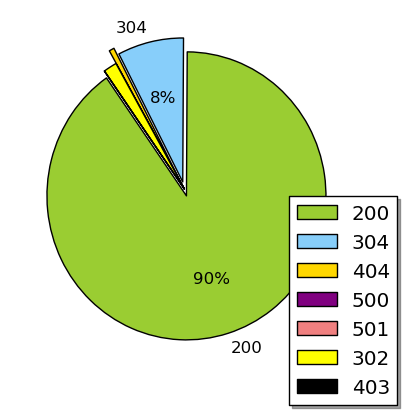

In [8]:
import matplotlib.pyplot as plt


def pie_pct_format(value):
   
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

In [9]:
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 404, 500, 501, 302, 403]
[0.9018981486363797, 0.07652801492518711, 0.005929617311989907, 1.9174186942570435e-06, 1.629805890118487e-05, 0.01557039850671432, 5.560514213345426e-05]


In [10]:
# hosts that have accessed the server multiple times (more than ten times)
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

Any 20 hosts that have accessed more then 10 times: [u'slip3.nilenet.com', u'client-71-31.online.apple.com', u'ix-jac2-16.ix.netcom.com', u'slip124.qlink.queensu.ca', u'ppp0e-01.rns.tamu.edu', u'ix-ftl2-16.ix.netcom.com', u'202.40.17.51', u'dialin14.wantree.com.au', u'y1a.kootenay.net', u'199.242.22.79', u'133.65.48.113', u'weird.stardust.com', u'ucsdtv2.ucsd.edu', u'dialup2.speed.net', u'147.150.5.96', u'pc-117.grassroots.ns.ca', u'152.52.29.20', u'asyn01.lw2.noord.bart.nl', u'bilbo.klautern.fh-rpl.de', u'cywilli.psdn177.pacbell.com']


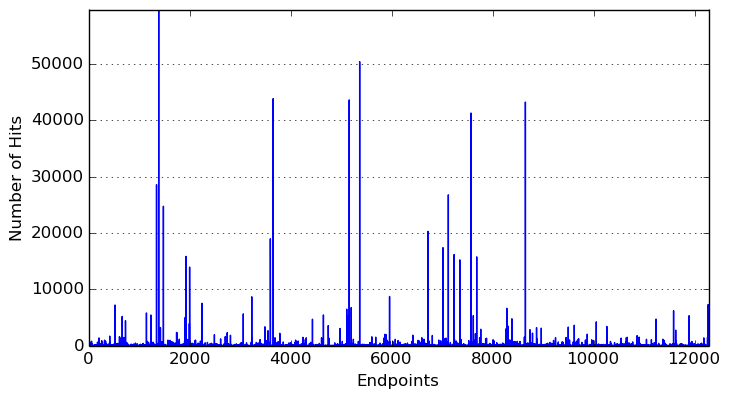

In [11]:
# visualize the number of hits to endpoints (URIs) in the log
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)
pass